# import packages and connect to google drive

In [11]:
# import the right packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import einops as eo # Added
import pathlib as pl # Added
import seaborn as sns

from mat73 import loadmat
import gc

from torch.utils.data import ConcatDataset

import wfdb
import ast
import pickle
import gzip
import random
import urllib.request
import shutil
import ast
from multiprocessing import Pool, cpu_count
# from tqdm import tqdm # Removed redundant import
import os
import itertools
import matplotlib.pyplot as plt
import matplotlib
import gdown
import json
from collections import defaultdict

import matplotlib.cm as cm
from matplotlib import collections  as mc
from matplotlib import animation

%matplotlib inline

from scipy.stats import norm
from scipy.stats import entropy
from scipy.ndimage import uniform_filter1d
from scipy.stats import pearsonr

import scipy.io as sio

from datetime import datetime

#transformer:
from transformers import AutoTokenizer, AutoModel



from PIL import Image
from time import time as timer
import umap

from IPython.display import HTML
from IPython.display import Audio
import IPython

from functools import partial
from collections import Counter

from tqdm.auto import tqdm # Corrected import to get the callable tqdm function

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F


import sys
#is_colab = 'google.colab' in sys.modules

# from google.colab import drive
# drive.mount('/content/drive')

# IMPORT MLFLOW
import mlflow


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

import glob
import vitaldb

import traceback






# Load data (do not rerun)

https://github.com/pulselabteam/PulseDB

https://www.frontiersin.org/journals/digital-health/articles/10.3389/fdgth.2022.1090854/full

it seems that I have shared the access to the file containing the segmented data in google drive. data are now at this link: https://drive.google.com/drive/folders/1QZ-Z-C9MoLk1S9MovF3Tt6NjAEGbSJI3

there is no need to download file

!!!!! for the shortcut: first ask to share the file. then the file will appeared in shared file in Gdrive. then create a shortcut to put it where you want it to be.

###################### Have to rerun this code to have the correct number of subjects....

In [6]:
# extract ecg and ppg data and save into.npy which are really lighter to work with: import numpy as np

# ==========================================
# CONFIGURATION
# ==========================================

data_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'  # Ensure this points to your LOCAL cache
batch_files = sorted(glob.glob(os.path.join(data_dir, 'PulseDB_Vital_Batch_*_Windowed_Synch.npz')))

print(f"Converting {len(batch_files)} files to .npy for efficient memmap...")

for f_path in tqdm(batch_files):
    # Define output paths for PPG and ECG separately
    # Example: batch_01.npz -> batch_01_ppg.npy AND batch_01_ecg.npy
    ppg_npy_path = f_path.replace('.npz', '_ppg.npy')
    ecg_npy_path = f_path.replace('.npz', '_ecg.npy')
    
    # Skip if both already exist
    if os.path.exists(ppg_npy_path) and os.path.exists(ecg_npy_path):
        continue
        
    try:
        # Load the original NPZ
        with np.load(f_path) as data:
            # 1. Save PPG
            if not os.path.exists(ppg_npy_path):
                ppg_windows = data['PPG_Windows'].astype(np.float32)
                np.save(ppg_npy_path, ppg_windows)
            
            # 2. Save ECG
            if not os.path.exists(ecg_npy_path):
                ecg_windows = data['ECG_Windows'].astype(np.float32)
                np.save(ecg_npy_path, ecg_windows)
            
    except Exception as e:
        print(f"Error converting {f_path}: {e}")

print("✅ Conversion complete: Created separate _ppg.npy and _ecg.npy files.")


Converting 59 files to .npy for efficient memmap...


  0%|          | 0/59 [00:00<?, ?it/s]

✅ Conversion complete: Created separate _ppg.npy and _ecg.npy files.


# Model 2: no double patch merging

### Module 1: dataloading and splitting with improve dataloader for faster computation

In [3]:
# new from regressor2
class PPG2ECGDataset(Dataset):
    def __init__(self, data_dir, limit_files=None):
        self.ppg_files = sorted(glob.glob(os.path.join(data_dir, '*_ppg.npy')))
        self.ecg_files = sorted(glob.glob(os.path.join(data_dir, '*_ecg.npy')))
        if limit_files:
            self.ppg_files, self.ecg_files = self.ppg_files[:limit_files], self.ecg_files[:limit_files]

        total_samples = sum(np.load(f, mmap_mode='r').shape[0] for f in self.ppg_files)
        
        # Pre-allocate RAM
        self.data_ppg = np.zeros((total_samples, 1, 500), dtype=np.float32)
        self.data_ecg = np.zeros((total_samples, 1, 500), dtype=np.float32)
        self.subject_ids = np.empty(total_samples, dtype=object)
        self.bmi_values = np.zeros(total_samples, dtype=np.float32) # For Regression
        self.bmi_labels = np.zeros(total_samples, dtype=np.int8)    # For Stratification

        curr_idx = 0
        for f_ppg, f_ecg in zip(tqdm(self.ppg_files, desc="RAM Load"), self.ecg_files):
            p, e = np.load(f_ppg), np.load(f_ecg)
            n = p.shape[0]
            
            npz_path = f_ppg.replace('_ppg.npy', '.npz')
            with np.load(npz_path, allow_pickle=True) as meta:
                # Column 4: continuous BMI, Column 5: BMI category code
                demo = meta['Demographics']
                self.subject_ids[curr_idx:curr_idx+n] = meta['SubjectIDs']
                self.bmi_values[curr_idx:curr_idx+n] = demo[:, 4].astype(np.float32)
                self.bmi_labels[curr_idx:curr_idx+n] = demo[:, 5].astype(np.int8)

            self.data_ppg[curr_idx:curr_idx+n] = p.reshape(-1, 1, 500)
            self.data_ecg[curr_idx:curr_idx+n] = e.reshape(-1, 1, 500)
            curr_idx += n

    def __len__(self): return len(self.data_ppg)
    def __getitem__(self, idx):
        return (torch.from_numpy(self.data_ppg[idx].copy()), 
                torch.from_numpy(self.data_ecg[idx].copy()), 
                torch.tensor(self.bmi_values[idx], dtype=torch.float32))

In [4]:
def create_random_stratified_splits(dataset, test_size=0.2, random_state=42):
    """
    Window-level random split stratified by BMI Category.
    Treats every window as independent to maximize shuffling [memory:1].
    """
    print(f"🏗️ Building window-level stratified splits...")
    indices = np.arange(len(dataset))
    labels = np.array(dataset.bmi_labels)
    
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(splitter.split(indices, labels))
    
    train_indices = indices[train_idx]
    val_indices = indices[val_idx]
    
    # Shuffle for training
    np.random.shuffle(train_indices)
    
    print(f"✅ Split Summary: Train: {len(train_indices):,} | Val: {len(val_indices):,}")
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

### Module 2: WINDOW ATTENTION - Modified to improve computation perf

In [5]:
class WindowAttention1D(nn.Module):
    """
    Window-based multi-head self-attention for 1D signals

    What it does:
    - Computes attention only within local windows (not globally)
    - Uses relative position bias (learned) instead of absolute positions
    - Enables efficient computation on long sequences

    Dimensions:
    Input: (batch_of_windows, window_size, dim)
    Output: (batch_of_windows, window_size, dim) - SAME SHAPE
    """
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # Relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1), num_heads)
        )

        # Generate relative position indices
        coords = torch.arange(window_size)
        relative_coords = coords[:, None] - coords[None, :]
        relative_coords += window_size - 1
        self.register_buffer("relative_position_index", relative_coords)

        # Q, K, V projections
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, x, mask=None):
        B_, N, C = x.shape  # B_=batch_of_windows, N=window_size, C=dim

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        # Add relative position bias
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(self.window_size, self.window_size, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            attn = attn + mask.unsqueeze(1).unsqueeze(0)

        attn = self.softmax(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)

        return x  # Same shape as input


### Module 3: SWIN TRANSFORMER BLOCK (optimzed for efficiency)

In [6]:
class SwinTransformerBlock1D(nn.Module):
    """
    Swin Transformer Block with shifted window mechanism

    What it does:
    - Applies layer normalization
    - Partitions sequence into windows
    - Shifts windows (if shift_size > 0) for cross-window connections
    - Applies window attention
    - Applies MLP with GELU activation
    - Uses residual connections (Add & Norm)

    Dimensions:
    Input: (B, L, C) where L=sequence_length, C=channels
    Output: (B, L, C) - SAME SHAPE

    Key: sequence length L must be divisible by window_size
    """
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # Layer normalization before attention
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention1D(dim, window_size, num_heads)

        # Layer normalization before MLP
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x)

        # Shifted window mechanism
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=-self.shift_size, dims=1)
        else:
            shifted_x = x

        # Partition into windows
        num_windows = L // self.window_size
        x_windows = shifted_x.view(B, num_windows, self.window_size, C)
        x_windows = x_windows.view(B * num_windows, self.window_size, C)

        # Window attention
        attn_windows = self.attn(x_windows)

        # Merge windows back
        attn_windows = attn_windows.view(B, num_windows, self.window_size, C)
        shifted_x = attn_windows.view(B, L, C)

        # Reverse shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=1)
        else:
            x = shifted_x

        # Add residual connection
        x = shortcut + x

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))

        return x  # Same shape as input


### Module 4: SIMPLIFIED SPA stage (modified from module 7)

In [7]:
class SimplifiedSPAStage(nn.Module):
    """
    Simplified SPA Stage - NO downsampling/upsampling

    What changed:
    - REMOVED: PatchMerging1D (was reducing sequence length)
    - REMOVED: PatchExpanding1D (was increasing sequence length)
    - KEPT: Multiple SwinTransformerBlocks with alternating shifts

    Why:
    - Maintains full sequence length (500) throughout
    - Multi-scale processing via different window_size, not downsampling
    - Simpler, more efficient, preserves temporal information

    Dimensions:
    Input: (B, L, dim) e.g., (32, 500, 96)
    Output: (B, L, dim) - EXACTLY SAME SHAPE
    """
    def __init__(self, dim, depth, num_heads, window_size):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size

        # Stack multiple Swin blocks with alternating shifted windows
        self.blocks = nn.ModuleList([
            SwinTransformerBlock1D(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2
            )
            for i in range(depth)
        ])

    def forward(self, x):
        """
        Forward pass through all blocks
        Input shape: (B, L, dim)
        Output shape: (B, L, dim) - NO CHANGE
        """
        for blk in self.blocks:
            x = blk(x)
        return x


### Module 5: COMPLETE SIMPLIFIED SPA encoder decoder

In [14]:
class SPAEncoderDecoderWithBMI(nn.Module):
    """
    Joint model for ECG reconstruction and BMI regression.
    """
    def __init__(self, in_channels=1, out_channels=1, embed_dim=96, num_heads=8, mlp_hidden_dim=64):
        super().__init__()

        # --- Autoencoder Backbone ---
        self.input_proj = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim), nn.GELU())

        self.encoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10)])
        


        self.decoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125)])

        self.skip_connections = nn.ModuleList([nn.Identity() for _ in range(5)])

        self.output_proj = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim // 2), nn.GELU(),
            nn.Conv1d(embed_dim // 2, out_channels, kernel_size=3, stride=1, padding=1))

        # --- BMI Regression Head (1-layer MLP) ---
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.bmi_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_dim, 1) # Output 1 continuous value
        )

    def forward(self, x):
        # Encoder
        x = self.input_proj(x).transpose(1, 2)
        encoder_features_list = []
        for stage in self.encoder_stages:
            x = stage(x)
            encoder_features_list.append(x)
        
        latent_features = x 

        # Decoder (for Reconstruction)
        dec_features = latent_features
        for i, stage in enumerate(self.decoder_stages):
            skip_feature = encoder_features_list[len(encoder_features_list) - 1 - i]
            dec_features = dec_features + self.skip_connections[i](skip_feature)
            dec_features = stage(dec_features)
        
        recon_ecg = self.output_proj(dec_features.transpose(1, 2))

        # BMI Head
        pooled_features = self.global_pool(latent_features.transpose(1, 2)).squeeze(-1)
        bmi_pred = self.bmi_head(pooled_features)

        return recon_ecg, bmi_pred.squeeze(-1)

In [8]:
class SimplifiedSPAEncoderDecoder(nn.Module):
    """
    Simplified SPA Encoder-Decoder for PPG to ECG reconstruction


    """
    def __init__(self, in_channels=1, out_channels=1, embed_dim=96, num_heads=8):
        super().__init__()

        self.embed_dim = embed_dim

        # ===================================================================
        # INPUT PROJECTION (REPLACED patch embedding)
        # ===================================================================
        # Simple 1D convolution to project signal to embedding dimension
        # Input: (B, 1, 500)
        # Output: (B, 96, 500) then transpose to (B, 500, 96)
        # ===================================================================
        self.input_proj = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim),
            nn.GELU()
        )

        # ===================================================================
        # ENCODER STAGES
        # ===================================================================
        # 5 stages with layer config {2, 2, 6, 6, 2}
        # Window sizes decrease: 125 → 100 → 50 → 25 → 10
        # This creates multi-scale processing:
        #   - Large windows (125): capture long-term patterns
        #   - Medium windows (50): capture beat-level features
        #   - Small windows (10): capture fine-grained details
        # ===================================================================
        # NOTE: 500 is divisible by 125,100,50,25,10 ✓
        # ===================================================================
        self.encoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),  # Stage 1
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),  # Stage 2
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),   # Stage 3
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),   # Stage 4
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),   # Stage 5 (bottleneck)
        ])

        # ===================================================================
        # DECODER STAGES
        # ===================================================================
        # Mirror encoder: 5 stages with layer config {2, 6, 6, 2, 2}
        # Window sizes increase: 10 → 25 → 50 → 100 → 125
        # Each stage receives skip connection from corresponding encoder stage
        # ===================================================================
        self.decoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),   # Stage 5 (bottleneck)
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),   # Stage 4
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),   # Stage 3
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),  # Stage 2
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),  # Stage 1
        ])

        # Skip connection projections (in case we want to add extra processing)
        self.skip_connections = nn.ModuleList([nn.Identity() for _ in range(5)])

        # ===================================================================
        # OUTPUT PROJECTION
        # ===================================================================
        # Project back from embedding dimension to output channels
        # Input: (B, 500, 96) transpose to (B, 96, 500)
        # Output: (B, 1, 500)
        # ===================================================================
        self.output_proj = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim // 2),
            nn.GELU(),
            nn.Conv1d(embed_dim // 2, out_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        """
        Forward pass through the complete model

        Input: x of shape (B, 1, 500) - PPG signal
        Output: reconstructed ECG of shape (B, 1, 500)

        Steps:
        1. Input projection: (B,1,500) → (B,500,96)
        2. Encoder stages with skip connections saved
        3. Decoder stages with skip connections added
        4. Output projection: (B,500,96) → (B,1,500)
        """
        B, C, L = x.shape  # e.g., (32, 1, 500)

        # ===================================================================
        # INPUT PROJECTION
        # ===================================================================
        x = self.input_proj(x)  # (B, 1, 500) → (B, 96, 500)
        x = x.transpose(1, 2)   # (B, 96, 500) → (B, 500, 96)

        # print(f"After input projection: {x.shape}")  # Debug: (B, 500, 96)

        # ===================================================================
        # ENCODER PATH
        # ===================================================================
        encoder_features = []
        for i, stage in enumerate(self.encoder_stages):
            x = stage(x)  # (B, 500, 96) → (B, 500, 96)
            encoder_features.append(x)
            # print(f"Encoder stage {i+1}: {x.shape}")  # Debug

        # ===================================================================
        # DECODER PATH WITH SKIP CONNECTIONS
        # ===================================================================
        for i, stage in enumerate(self.decoder_stages):
            # Get corresponding encoder feature (reversed order)
            skip_idx = len(encoder_features) - 1 - i
            skip_feature = encoder_features[skip_idx]

            # Add skip connection
            x = x + self.skip_connections[i](skip_feature)

            # Process through decoder stage
            x = stage(x)  # (B, 500, 96) → (B, 500, 96)
            # print(f"Decoder stage {i+1} (with skip): {x.shape}")  # Debug

        # ===================================================================
        # OUTPUT PROJECTION
        # ===================================================================
        x = x.transpose(1, 2)   # (B, 500, 96) → (B, 96, 500)
        x = self.output_proj(x)  # (B, 96, 500) → (B, 1, 500)

        # print(f"Final output: {x.shape}")  # Debug: (B, 1, 500)

        return x

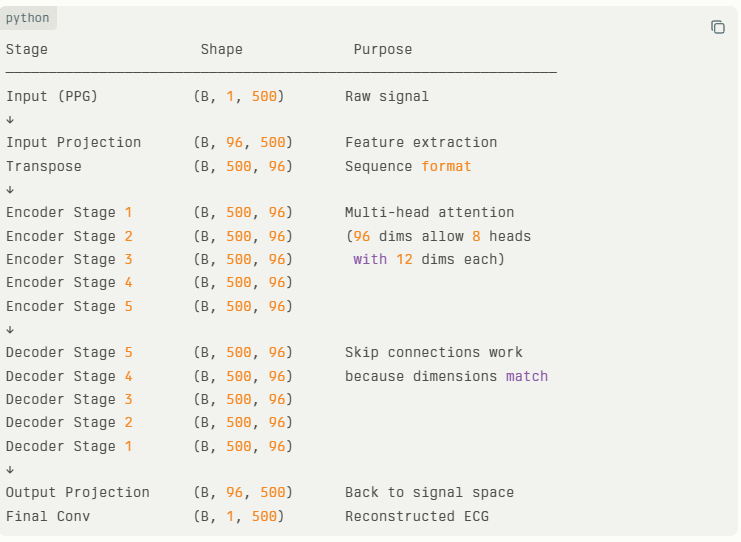

### Module 7: test 

# IMPORTANT NOTE FOR MLFLOW

this is what must be run in BASH terminal to access myenv, and then run MLFLOW: 

CO@Famille MINGW64 ~
$ cd /c/Users/CO/myenv

CO@Famille MINGW64 ~/myenv
$ source Scripts/activate
(myenv) 

CO@Famille MINGW64 ~/myenv
$ mlflow ui
or 
$ $ mlflow ui --backend-store-uri "sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db"

Run this code first in BASH, then run MODULE 7 test: and results will appear!!!

then open http://localhost:5000

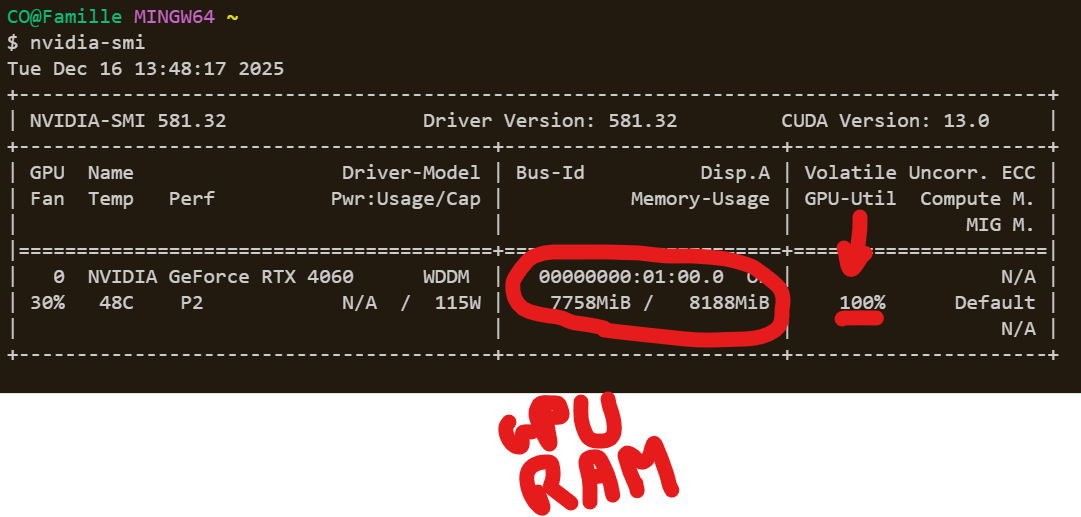

use non crashing VScode approach

In [9]:
# --- Plotting Helper Function ---
def plot_joint_results(history, actuals, preds, save_dir):
    """Generates a dashboard showing training history and regression performance."""
    plt.figure(figsize=(18, 5))
    
    # 1. Total Loss History
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Total Joint Loss (L1 + MSE)')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    # 2. BMI MAE History (to be consistent with AnyPPG)
    plt.subplot(1, 3, 2)
    plt.plot(history['train_mae_bmi'], label='Train')
    plt.plot(history['val_mae_bmi'], label='Val')
    plt.title('BMI Regression MAE')
    plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend()

    # 3. Predicted vs Actual BMI (Best Model Performance)
    plt.subplot(1, 3, 3)
    sns.regplot(x=actuals, y=preds, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
    plt.title(f'BMI Pred vs Actual\n(Best MAE: {min(history["val_mae_bmi"]):.4f})')
    plt.xlabel('Actual BMI'); plt.ylabel('Predicted BMI')
    
    plt.tight_layout()
    plot_path = os.path.join(save_dir, 'training_dashboard.png')
    plt.savefig(plot_path, dpi=300)
    mlflow.log_artifact(plot_path)
    plt.show()


In [ ]:
# New tracking URI and experiment for the Autoencoder-only run
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
mlflow.set_experiment("AE_ONLY_PPG-ECG_RandomSplit")


if __name__ == "__main__":
    # --- CONFIGURATION ---
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model_AE_Only_RandomSplit'
    
    # RTX 4060 Tuning: 8GB VRAM limit requires slightly smaller batches than high-end cards [web:6][web:9].
    # num_workers=0 is used to avoid Windows-specific multiprocessing overhead [web:7].
    BATCH_SIZE = 48  
    NUM_EPOCHS = 2
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_ae_last.pth')
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_ae_model.pth')
    SAVE_EVERY_N_BATCHES = 1500 

    os.makedirs(save_dir, exist_ok=True)
    
    with mlflow.start_run(run_name="AE_Reconstruction_Only") as run:
        mlflow.log_params({"batch_size": BATCH_SIZE, "model": "AE_Only", "device": "RTX_4060"})

        try:
            # 1. DATA PREPARATION
            full_dataset = PPG2ECGDataset(windowed_dir)
            train_ds, val_ds = create_random_stratified_splits(full_dataset)
            
            # pin_memory=True speeds up transfer to GPU [web:5].
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

            # 2. INITIALIZATION (Assuming SPAEncoderDecoder exists without BMI head)
            # If your model still has the head, we ignore the second output.
            model = SPAEncoderDecoderWithBMI(embed_dim=96, num_heads=8).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
            scaler = torch.amp.GradScaler(enabled=(DEVICE == 'cuda'))
            
            recon_criterion = nn.MSELoss()

            # 3. RESUME LOGIC
            start_epoch, start_batch, best_val_loss = 0, 0, float('inf')
            history = {'train_loss':[], 'val_loss':[]}

            if os.path.exists(CHECKPOINT_PATH):
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                print(f"🔄 Resumed at Epoch {start_epoch+1}")

            # 4. TRAINING LOOP
            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                t_loss = 0
                pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
                
                for batch_idx, (ppg, ecg, _) in pbar:
                    ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                    
                    optimizer.zero_grad()
                    with torch.amp.autocast('cuda'):
                        # Ignore the BMI prediction head output (_)
                        recon, _ = model(ppg)
                        loss = recon_criterion(recon, ecg)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    t_loss += loss.item()

                    if batch_idx % SAVE_EVERY_N_BATCHES == 0 and batch_idx > 0:
                        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'best_val_loss': best_val_loss}, CHECKPOINT_PATH)

                # 5. VALIDATION
                model.eval()
                v_loss = 0
                with torch.no_grad():
                    for ppg, ecg, _ in tqdm(val_loader, desc="Val"):
                        ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                        with torch.amp.autocast('cuda'):
                            recon, _ = model(ppg)
                            loss = recon_criterion(recon, ecg)
                        v_loss += loss.item()

                # LOGGING
                avg_train_loss = t_loss / len(train_loader)
                avg_val_loss = v_loss / len(val_loader)
                
                mlflow.log_metrics({"train_loss": avg_train_loss, "val_loss": avg_val_loss}, step=epoch+1)
                print(f"Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
                
                scheduler.step(avg_val_loss)
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save(model.state_dict(), BEST_MODEL_PATH)
                    print(f"  ⭐ New Best Val Loss: {best_val_loss:.6f}")

        except Exception as e:
            traceback.print_exc()
        finally:
            if torch.cuda.is_available(): 
                torch.cuda.empty_cache()


RAM Load:   0%|          | 0/59 [00:00<?, ?it/s]

🏗️ Building window-level stratified splits...
✅ Split Summary: Train: 4,654,240 | Val: 1,163,560


Epoch 1:   0%|          | 0/96964 [00:00<?, ?it/s]

In [ ]:
class SPAEncoderDecoderWithBMI(nn.Module):
    """
    Joint model for ECG reconstruction and BMI regression.
    """
    def __init__(self, in_channels=1, out_channels=1, embed_dim=96, num_heads=8, mlp_hidden_dim=64):
        super().__init__()

        # --- Autoencoder Backbone ---
        self.input_proj = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim), nn.GELU())

        self.encoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10)])
        


        self.decoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125)])

        self.skip_connections = nn.ModuleList([nn.Identity() for _ in range(5)])

        self.output_proj = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim // 2), nn.GELU(),
            nn.Conv1d(embed_dim // 2, out_channels, kernel_size=3, stride=1, padding=1))

        # --- BMI Regression Head (1-layer MLP) ---
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.bmi_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_dim, 1) # Output 1 continuous value
        )

    def forward(self, x):
        # Encoder
        x = self.input_proj(x).transpose(1, 2)
        encoder_features_list = []
        for stage in self.encoder_stages:
            x = stage(x)
            encoder_features_list.append(x)
        
        latent_features = x 

        # Decoder (for Reconstruction)
        dec_features = latent_features
        for i, stage in enumerate(self.decoder_stages):
            skip_feature = encoder_features_list[len(encoder_features_list) - 1 - i]
            dec_features = dec_features + self.skip_connections[i](skip_feature)
            dec_features = stage(dec_features)
        
        recon_ecg = self.output_proj(dec_features.transpose(1, 2))

        # BMI Head
        pooled_features = self.global_pool(latent_features.transpose(1, 2)).squeeze(-1)
        bmi_pred = self.bmi_head(pooled_features)

        return recon_ecg, bmi_pred.squeeze(-1)

need to install a torch that is compatible and optimized for RTX 4060's sm_89. run this code in BASH: RTX 4060's sm_89 (in myenv, and after removing the old torch version)

In [ ]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0)}")
print(f"Compute Capability: {torch.cuda.get_device_capability(0)}")


In [ ]:

# CRITICAL FIX: Set backend to non-interactive to prevent VSCode UI crashes

matplotlib.use('Agg') #@@@@@@@@@@ not used

# ------------------------------------------------------------------
# GLOBAL CONFIG
# ------------------------------------------------------------------
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
mlflow.set_experiment("Model2.1_simplified_normalized")

# RTX 4060 Optimization
torch.set_float32_matmul_precision('high') #@@@@@@@@@@@@@@ not used

if __name__ == "__main__":
    # Clear cache immediately upon start
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    print("\n" + "="*80)
    print("MAIN EXECUTION - OPTIMIZED SPA MODEL")
    print("="*80)

    # ========================================================================
    # CONFIGURATION
    # ========================================================================
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized5' 

    BATCH_SIZE = 256 
    NUM_EPOCHS = 2
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_last_customized.pth')
    SAVE_EVERY_N_BATCHES= 1000
    
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_simplified_customized_spa_model.pth')

    # ========================================================================
    # START MLFLOW RUN
    # ========================================================================
    with mlflow.start_run(run_name="Model2.1_simplified_optimized_intraepoch_check") as run:
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "device": DEVICE,
            "optimization": "TF32_Enabled_AggBackend"
        })

        try:

             # 1. DATA PREP
             full_dataset = PPG2ECGDataset(windowed_dir)
             trains_ds, val_ds = Splitfunction (full_dataset) #@@@@@@@@@@@@ define split function

            # Windows-Safe Settings
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # try with pin_memory=True, if not have False
            val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
          
            
            print(f"✅ Loaded {len(train_dataset)} training samples.")
            
            # Free up memory used during dataset initialization logic
            gc.collect() 
        
            # 2. INITIALIZATION
            model = SPAEncoderDecoderWithBMI(embed_dim=96, num_heads=8).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
            scaler = torch.amp.GradScaler(enabled=(DEVICE == 'cuda'))
            criterion = nn.MSELoss()

            
            # 3. RESUME LOGIC
            start_epoch, train_losses, val_losses = 0, [], [], float('inf')
            history = {'train_losses':[], 'val_losses':[]}


            # os.makedirs(save_dir, exist_ok=True) #@@@@@@@@@@@@@@@@@@@@@@@@@@@

            if os.path.exists(CHECKPOINT_PATH):
                print(f"🔄 Resuming from: {CHECKPOINT_PATH}")
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch, start_batch = checkpoint['epoch'], checkpoint.get('batch_idx', 0) + 1
                #train_losses = checkpoint.get('train_losses', []) # @@@@@@@@@@@@@@@@@@@@@@@
                #val_losses = checkpoint.get('val_losses', []) # @@@@@@@@@@@@@@@@@@@@@@@
                best_val_rmse = checkpoint.get('best_val_rmse', float('inf'))
                del checkpoint # Free memory immediately
                gc.collect()

            # 4. TRAINING
            
            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                running_loss = 0.0
                
                # OPTIMIZATION: mininterval=1.0 prevents terminal flooding/freezing
                pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS} [Train]", 
                           leave=False, mininterval=1.0)
                
                for ppg, ecg in pbar:
                    ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                    
                    optimizer.zero_grad() # Slightly faster than zero_grad()
                    
                    with torch.amp.autocast('cuda'):
                        output = model(ppg)
                        loss = criterion(output, ecg)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    running_loss += loss.item()
                
                avg_train_loss = running_loss / len(train_loader)
                train_rmse = np.sqrt(avg_train_loss)
                train_losses.append(train_rmse)

                if batch_idx % SAVE_EVERY_N_BATCHES == 0 and batch_idx > 0:
                        torch.save({'epoch': epoch, 'batch_idx': batch_idx, 'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(), 'history': history,
                                    'best_val_bmi_rmse': best_val_bmi_rmse}, CHECKPOINT_PATH)

                # Validation
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for ppg, ecg in val_loader:
                        ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                        output = model(ppg)
                        loss = criterion(output, ecg)
                        val_loss += loss.item()
                
                avg_val_loss = val_loss / len(val_loader)
                val_rmse = np.sqrt(avg_val_loss)
                val_losses.append(val_rmse)
                
                scheduler.step(val_loss)

                # Logging
                print(f"   RESULTS: Train RMSE: {train_rmse:.5f} | Val RMSE: {val_rmse:.5f}")
                mlflow.log_metrics({
                    "train_rmse": train_rmse, 
                    "val_rmse": val_rmse,
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss
                }, step=epoch+1)

                # Save Checkpoints
                # OPTIMIZATION: Construct dict directly in call to save memory
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'best_val_rmse': best_val_rmse,
                }, CHECKPOINT_PATH)

                # Save best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    torch.save(model.state_dict(), BEST_MODEL_PATH) # Save ONLY state_dict for best model
                    print(f"   🌟 New Best Model Saved (RMSE: {best_val_rmse:.5f})")
                    # OPTIMIZATION: Log artifact (file) instead of full model object (faster, lighter)
                    mlflow.log_artifact(BEST_MODEL_PATH, artifact_path="models")

                # Force cleanup after each epoch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

            # ====================================================================
            # VISUALIZATION & WRAP UP
            # ====================================================================
            print("\n[4/5] Generating Visualizations...")
            
            # 1. Plot History
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train RMSE')
            plt.plot(val_losses, label='Val RMSE')
            plt.title(f'Training History (Best: {best_val_rmse:.4f})')
            plt.legend()
            plt.grid(True, alpha=0.3)
            hist_path = os.path.join(save_dir, 'history_optimized.png')
            plt.savefig(hist_path)
            plt.close() # Vital to close figure to free memory
            mlflow.log_artifact(hist_path)

            # 2. Plot Reconstructions (Sample)
            model.eval()
            with torch.no_grad():
                # Get one batch only
                ppg_batch, ecg_batch = next(iter(val_loader))
                # Take first 3 samples
                ppg_sample = ppg_batch[:3].to(DEVICE)
                ecg_sample = ecg_batch[:3].cpu().numpy()
                output_sample = model(ppg_sample).cpu().numpy()
                
                fig, axes = plt.subplots(3, 1, figsize=(10, 8))
                for i in range(3):
                    axes[i].plot(ecg_sample[i].flatten(), 'b-', label='Target', alpha=0.7)
                    axes[i].plot(output_sample[i].flatten(), 'r--', label='Pred', linewidth=1)
                    axes[i].set_title(f"Sample {i+1}")
                plt.tight_layout()
                rec_path = os.path.join(save_dir, 'reconstructions_optimized.png')
                plt.savefig(rec_path)
                plt.close()
                mlflow.log_artifact(rec_path)

            print("\n" + "="*80)
            print(f"✅ SUCCESS. Best RMSE: {best_val_rmse:.5f}")
            print(f"   Saved to: {save_dir}")
            print("="*80)

        except Exception as e:
            print(f"\n❌ CRASH PREVENTED: {str(e)}")
            import traceback
            traceback.print_exc()
        finally:
            # Ensure resources are released even if error occurs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()


In [27]:

# CRITICAL FIX: Set backend to non-interactive to prevent VSCode UI crashes

matplotlib.use('Agg') 

import gc # Garbage collector for memory management

# ------------------------------------------------------------------
# GLOBAL CONFIG
# ------------------------------------------------------------------
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
mlflow.set_experiment("Model2.1_simplified_normalized")

# RTX 4060 Optimization
torch.set_float32_matmul_precision('high') 

if __name__ == "__main__":
    # Clear cache immediately upon start
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    print("\n" + "="*80)
    print("MAIN EXECUTION - OPTIMIZED SPA MODEL")
    print("="*80)

    # ========================================================================
    # CONFIGURATION
    # ========================================================================
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized5'
    
    # OPTIMIZATION: Reduced Batch Size slightly to prevent VRAM spikes during backward pass
    # If 350 was crashing, 256 is a safer, highly optimized power-of-2 number for GPUs.
    BATCH_SIZE = 256 
    NUM_EPOCHS = 2
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_last_customized.pth')
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_simplified_customized_spa_model.pth')

    # ========================================================================
    # START MLFLOW RUN
    # ========================================================================
    with mlflow.start_run(run_name="Model2.1_simplified_optimized") as run:
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "device": DEVICE,
            "optimization": "TF32_Enabled_AggBackend"
        })

        try:
            # ====================================================================
            # LOAD DATASETS
            # ====================================================================
            print("\n[1/5] Loading Datasets...")
            train_dataset = PPG2ECGDataset(windowed_dir, split='train')
            val_dataset = PPG2ECGDataset(windowed_dir, split='test')
            
            # OPTIMIZATION: num_workers=0 is safest for VSCode. 
            # pin_memory=False reduces system RAM pressure if your machine is crashing.
            train_loader = DataLoader(
                train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                num_workers=0, pin_memory=False 
            )
            val_loader = DataLoader(
                val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                num_workers=0, pin_memory=False
            )
            
            print(f"✅ Loaded {len(train_dataset)} training samples.")
            
            # Free up memory used during dataset initialization logic
            gc.collect() 

            # ====================================================================
            # INITIALIZE MODEL
            # ====================================================================
            print("\n[2/5] Initializing Model...")
            model = SimplifiedSPAEncoderDecoder(
                in_channels=1, out_channels=1, embed_dim=96, num_heads=8
            ).to(DEVICE)

            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
            criterion = nn.MSELoss()
            
            # Enable Mixed Precision Scaler
            scaler = torch.amp.GradScaler('cuda')

            # ====================================================================
            # RESUME CHECKPOINT
            # ====================================================================
            start_epoch = 0
            train_losses, val_losses = [], []
            best_val_rmse = float('inf')
            os.makedirs(save_dir, exist_ok=True)

            if os.path.exists(CHECKPOINT_PATH):
                print(f"🔄 Resuming from: {CHECKPOINT_PATH}")
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                train_losses = checkpoint.get('train_losses', [])
                val_losses = checkpoint.get('val_losses', [])
                best_val_rmse = checkpoint.get('best_val_rmse', float('inf'))
                del checkpoint # Free memory immediately
                gc.collect()

            # ====================================================================
            # TRAINING LOOP
            # ====================================================================
            print(f"\n[3/5] Starting Training (Epochs {start_epoch+1}-{NUM_EPOCHS})...")
            
            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                running_loss = 0.0
                
                # OPTIMIZATION: mininterval=1.0 prevents terminal flooding/freezing
                pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS} [Train]", 
                           leave=False, mininterval=1.0)
                
                for ppg, ecg in pbar:
                    ppg, ecg = ppg.to(DEVICE, non_blocking=True), ecg.to(DEVICE, non_blocking=True)
                    
                    optimizer.zero_grad(set_to_none=True) # Slightly faster than zero_grad()
                    
                    with torch.amp.autocast('cuda'):
                        output = model(ppg)
                        loss = criterion(output, ecg)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    running_loss += loss.item()
                
                avg_train_loss = running_loss / len(train_loader)
                train_rmse = np.sqrt(avg_train_loss)
                train_losses.append(train_rmse)

                # Validation
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for ppg, ecg in val_loader:
                        ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                        output = model(ppg)
                        loss = criterion(output, ecg)
                        val_loss += loss.item()
                
                avg_val_loss = val_loss / len(val_loader)
                val_rmse = np.sqrt(avg_val_loss)
                val_losses.append(val_rmse)
                
                scheduler.step(val_loss)

                # Logging
                print(f"   RESULTS: Train RMSE: {train_rmse:.5f} | Val RMSE: {val_rmse:.5f}")
                mlflow.log_metrics({
                    "train_rmse": train_rmse, 
                    "val_rmse": val_rmse,
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss
                }, step=epoch+1)

                # Save Checkpoints
                # OPTIMIZATION: Construct dict directly in call to save memory
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'best_val_rmse': best_val_rmse,
                }, CHECKPOINT_PATH)

                # Save best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    torch.save(model.state_dict(), BEST_MODEL_PATH) # Save ONLY state_dict for best model
                    print(f"   🌟 New Best Model Saved (RMSE: {best_val_rmse:.5f})")
                    # OPTIMIZATION: Log artifact (file) instead of full model object (faster, lighter)
                    mlflow.log_artifact(BEST_MODEL_PATH, artifact_path="models")

                # Force cleanup after each epoch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

            # ====================================================================
            # VISUALIZATION & WRAP UP
            # ====================================================================
            print("\n[4/5] Generating Visualizations...")
            
            # 1. Plot History
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train RMSE')
            plt.plot(val_losses, label='Val RMSE')
            plt.title(f'Training History (Best: {best_val_rmse:.4f})')
            plt.legend()
            plt.grid(True, alpha=0.3)
            hist_path = os.path.join(save_dir, 'history_optimized.png')
            plt.savefig(hist_path)
            plt.close() # Vital to close figure to free memory
            mlflow.log_artifact(hist_path)

            # 2. Plot Reconstructions (Sample)
            model.eval()
            with torch.no_grad():
                # Get one batch only
                ppg_batch, ecg_batch = next(iter(val_loader))
                # Take first 3 samples
                ppg_sample = ppg_batch[:3].to(DEVICE)
                ecg_sample = ecg_batch[:3].cpu().numpy()
                output_sample = model(ppg_sample).cpu().numpy()
                
                fig, axes = plt.subplots(3, 1, figsize=(10, 8))
                for i in range(3):
                    axes[i].plot(ecg_sample[i].flatten(), 'b-', label='Target', alpha=0.7)
                    axes[i].plot(output_sample[i].flatten(), 'r--', label='Pred', linewidth=1)
                    axes[i].set_title(f"Sample {i+1}")
                plt.tight_layout()
                rec_path = os.path.join(save_dir, 'reconstructions_optimized.png')
                plt.savefig(rec_path)
                plt.close()
                mlflow.log_artifact(rec_path)

            print("\n" + "="*80)
            print(f"✅ SUCCESS. Best RMSE: {best_val_rmse:.5f}")
            print(f"   Saved to: {save_dir}")
            print("="*80)

        except Exception as e:
            print(f"\n❌ CRASH PREVENTED: {str(e)}")
            import traceback
            traceback.print_exc()
        finally:
            # Ensure resources are released even if error occurs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()



MAIN EXECUTION - OPTIMIZED SPA MODEL

[1/5] Loading Datasets...
🚀 Loading 59 files into RAM for split 'train'...
   (This creates ~24GB of arrays, please wait 1-2 mins...)


Reading Files:   0%|          | 0/59 [00:00<?, ?it/s]

   Concatenating arrays...
✅ Loaded 4,654,240 samples into RAM.
🚀 Loading 59 files into RAM for split 'test'...
   (This creates ~24GB of arrays, please wait 1-2 mins...)


Reading Files:   0%|          | 0/59 [00:00<?, ?it/s]

   Concatenating arrays...
✅ Loaded 1,163,560 samples into RAM.
✅ Loaded 4654240 training samples.

[2/5] Initializing Model...

[3/5] Starting Training (Epochs 1-2)...


Ep 1/2 [Train]:   0%|          | 0/18181 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =========================
# MLFLOW + TRAINING (CLEAN)
# =========================
import os
import time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import mlflow

# -------------------------
# MLflow setup
# -------------------------
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
print("TRACKING URI (code):", mlflow.get_tracking_uri())
mlflow.set_experiment("Model2.1_simplified_normalized")

# Speed: TF32 on RTX 40xx
torch.set_float32_matmul_precision('high')

if __name__ == "__main__":
    print("\n" + "=" * 80)
    print("MAIN EXECUTION - SIMPLIFIED SPA MODEL WITH MLFLOW TRACKING")
    print("=" * 80)

    # -------------------------
    # CONFIG
    # -------------------------
    windowed_dir = r"C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro"
    save_dir = r"C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized5"

    BATCH_SIZE = 350
    EFFECTIVE_BATCH = 1050
    ACCUM_STEPS = max(1, EFFECTIVE_BATCH // BATCH_SIZE)  # e.g., 1050//350 = 3
    NUM_EPOCHS = 2
    LEARNING_RATE = 1e-4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    CHECKPOINT_PATH = os.path.join(save_dir, "checkpoint_last_customized.pth")
    BEST_MODEL_PATH = os.path.join(save_dir, "best_simplified_customized_spa_model.pth")
    os.makedirs(save_dir, exist_ok=True)

    print("\nConfiguration:")
    print(f"  Data directory: {windowed_dir}")
    print(f"  Save directory: {save_dir}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Effective batch: {EFFECTIVE_BATCH}")
    print(f"  Accum steps: {ACCUM_STEPS}")
    print(f"  Epochs: {NUM_EPOCHS}")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Device: {DEVICE}")

    with mlflow.start_run(run_name="Model2.1_simplified_customized5_completeDataSet"):
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "effective_batch": EFFECTIVE_BATCH,
            "accum_steps": ACCUM_STEPS,
            "windowed_dir": windowed_dir,
            "num_epochs": NUM_EPOCHS,
            "learning_rate": LEARNING_RATE,
            "weight_decay": 1e-5,
            "embed_dim": 96,
            "num_heads": 8,
            "device": DEVICE,
            "save_dir": save_dir,
        })

        try:
            # -------------------------
            # DATA
            # -------------------------
            print("\n" + "=" * 80)
            print("LOADING DATASETS")
            print("=" * 80)

            train_dataset = PPG2ECGDataset(windowed_dir, split="train")
            val_dataset = PPG2ECGDataset(windowed_dir, split="test")

            print("✅ Datasets loaded:")
            print(f"  Train samples: {len(train_dataset):,}")
            print(f"  Val samples: {len(val_dataset):,}")

            train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=0,          # Windows-safe
                pin_memory=True
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )

            # -------------------------
            # MODEL
            # -------------------------
            print("\n" + "=" * 80)
            print("INITIALIZING MODEL")
            print("=" * 80)

            model = SimplifiedSPAEncoderDecoder(
                in_channels=1, out_channels=1, embed_dim=96, num_heads=8
            ).to(DEVICE)

            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.5, patience=8
            )
            criterion = nn.MSELoss()

            # AMP setup (create scaler BEFORE diagnostics and training)
            use_cuda = (DEVICE == "cuda")
            if use_cuda:
                torch.backends.cudnn.benchmark = True
                scaler = torch.amp.GradScaler("cuda")
            else:
                scaler = None

            # -------------------------
            # CHECKPOINT
            # -------------------------
            start_epoch = 0
            train_losses, val_losses = [], []
            best_val_rmse = float("inf")

            if os.path.exists(CHECKPOINT_PATH):
                print(f"\n🔄 Found checkpoint at {CHECKPOINT_PATH}")
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
                model.load_state_dict(checkpoint["model_state_dict"])
                optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
                start_epoch = checkpoint["epoch"] + 1
                train_losses = checkpoint.get("train_losses", [])
                val_losses = checkpoint.get("val_losses", [])
                best_val_rmse = checkpoint.get("best_val_rmse", float("inf"))
                print("✅ Checkpoint loaded successfully!")
                print(f"  Resuming from epoch: {start_epoch + 1}")
                print(f"  Best Val RMSE so far: {best_val_rmse:.6f}")
            else:
                print("\n📝 No checkpoint found. Starting training from scratch...")

            total_params = sum(p.numel() for p in model.parameters())
            print("\n✅ Model ready:")
            print(f"  Total parameters: {total_params:,}")
            print(f"  Device: {DEVICE}")

            # -------------------------
            # ONE-TIME DIAGNOSTIC
            # -------------------------
            print("\n" + "=" * 80)
            print("QUICK SPEED DIAGNOSTIC (warmup + timed 20 iters)")
            print("=" * 80)

            model.train()

            # Warmup (5 iters)
            for i, (ppg, ecg) in enumerate(train_loader):
                if i == 5:
                    break
                ppg = ppg.to(DEVICE, non_blocking=True)
                ecg = ecg.to(DEVICE, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast(device_type="cuda", enabled=use_cuda):
                    out = model(ppg)
                    loss = criterion(out, ecg)

                if use_cuda:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

            if use_cuda:
                torch.cuda.synchronize()

            # Timed run (20 iters)
            t0 = time.time()
            for i, (ppg, ecg) in enumerate(train_loader):
                if i == 20:
                    break
                ppg = ppg.to(DEVICE, non_blocking=True)
                ecg = ecg.to(DEVICE, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast(device_type="cuda", enabled=use_cuda):
                    out = model(ppg)
                    loss = criterion(out, ecg)

                if use_cuda:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

            if use_cuda:
                torch.cuda.synchronize()

            sec_per_iter = (time.time() - t0) / 20
            print(f"sec/iter (20 iters): {sec_per_iter:.4f}")

            # Uncomment next line if you want to stop after diagnostics############################################################################### remove this after!!!!!!!!!!!!!!!!!!!!!!!
            raise SystemExit("Diagnostic complete. Comment this line to run full training.")

            # -------------------------
            # TRAINING LOOP
            # -------------------------
            print("\n" + "=" * 80)
            print("TRAINING MODEL WITH MLFLOW")
            print("=" * 80)
            print(f"Training from epoch {start_epoch + 1} to {NUM_EPOCHS}")

            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                train_loss_sum = 0.0
                train_batches = 0

                print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
                print("-" * 80)

                optimizer.zero_grad(set_to_none=True)

                for batch_idx, (ppg, ecg) in enumerate(tqdm(train_loader, desc="Training")):
                    ppg = ppg.to(DEVICE, non_blocking=True)
                    ecg = ecg.to(DEVICE, non_blocking=True)

                    with torch.amp.autocast(device_type="cuda", enabled=use_cuda):
                        out = model(ppg)
                        loss = criterion(out, ecg)
                        loss = loss / ACCUM_STEPS

                    if use_cuda:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()

                    # Step every ACCUM_STEPS
                    if (batch_idx + 1) % ACCUM_STEPS == 0:
                        if use_cuda:
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            optimizer.step()
                        optimizer.zero_grad(set_to_none=True)

                    train_loss_sum += loss.item() * ACCUM_STEPS  # undo division for logging
                    train_batches += 1

                avg_train_loss = train_loss_sum / train_batches
                train_rmse = float(np.sqrt(avg_train_loss))
                train_losses.append(train_rmse)

                # -------------------------
                # VALIDATION
                # -------------------------
                model.eval()
                val_loss_sum = 0.0
                val_batches = 0

                with torch.no_grad():
                    for ppg, ecg in tqdm(val_loader, desc="Validation"):
                        ppg = ppg.to(DEVICE, non_blocking=True)
                        ecg = ecg.to(DEVICE, non_blocking=True)
                        with torch.amp.autocast(device_type="cuda", enabled=use_cuda):
                            out = model(ppg)
                            loss = criterion(out, ecg)
                        val_loss_sum += loss.item()
                        val_batches += 1

                avg_val_loss = val_loss_sum / val_batches
                val_rmse = float(np.sqrt(avg_val_loss))
                val_losses.append(val_rmse)

                print(f"Epoch {epoch+1}/{NUM_EPOCHS} Results:")
                print(f"  Train RMSE: {train_rmse:.6f}")
                print(f"  Val RMSE: {val_rmse:.6f}")

                # MLflow metrics
                mlflow.log_metric("train_rmse", train_rmse, step=epoch+1)
                mlflow.log_metric("val_rmse", val_rmse, step=epoch+1)
                mlflow.log_metric("train_loss", avg_train_loss, step=epoch+1)
                mlflow.log_metric("val_loss", avg_val_loss, step=epoch+1)

                # Scheduler (optional)
                scheduler.step(avg_val_loss)

                # Save checkpoint
                checkpoint = {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "best_val_rmse": best_val_rmse,
                }
                torch.save(checkpoint, CHECKPOINT_PATH)
                mlflow.log_artifact(CHECKPOINT_PATH, artifact_path="checkpoints")

                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    torch.save({
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "train_rmse": train_rmse,
                        "val_rmse": val_rmse,
                    }, BEST_MODEL_PATH)
                    print(f"  ✅ Best model saved! (Val RMSE: {best_val_rmse:.6f})")
                    mlflow.log_artifact(BEST_MODEL_PATH, artifact_path="best_model")

        except Exception as e:
            print(f"\n❌ ERROR: {str(e)}")
            import traceback
            traceback.print_exc()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print("✅ CUDA cache cleared")



TRACKING URI (code): sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db

MAIN EXECUTION - SIMPLIFIED SPA MODEL WITH MLFLOW TRACKING

Configuration:
  Data directory: C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro
  Save directory: C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized5
  Batch size: 350
  Effective batch: 1050
  Accum steps: 3
  Epochs: 2
  Learning rate: 0.0001
  Device: cuda

LOADING DATASETS
Pre-opening memory maps...
✅ Indexed 4654240 samples for train set.
Pre-opening memory maps...
✅ Indexed 1163560 samples for test set.
✅ Datasets loaded:
  Train samples: 4,654,240
  Val samples: 1,163,560

INITIALIZING MODEL

📝 No checkpoint found. Starting training from scratch...

✅ Model ready:
  Total parameters: 4,070,081
  Device: cuda

QUICK SPEED DIAGNOSTIC (warmup + timed 20 iters)


## FAST TEST

In [41]:
################ FAST TEST

#------------------------------------------------------------------
mlflow.set_tracking_uri(
    r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db"
)
print("TRACKING URI (code):", mlflow.get_tracking_uri())

#------------------------------------------------------------------

# Set MLflow experiment BEFORE main execution
mlflow.set_experiment("Model2.1_simplified_normalized")

# model with check_points, learning rate scheduler, early stopping, weigth decay, batch size =32
if __name__ == "__main__":
    print("\n" + "="*80)
    print("MAIN EXECUTION - SIMPLIFIED SPA MODEL WITH MLFLOW TRACKING")
    print("="*80)

    # ========================================================================
    # CONFIGURATION
    # ========================================================================
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_test'
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized3'

    BATCH_SIZE = 512        # ⚡ Bigger = fewer iterations
    NUM_EPOCHS = 1           # ⚡ Single epoch
    LEARNING_RATE = 0.001    # ⚡ Doesn't matter for test
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_last_customized.pth')
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_simplified_customized_spa_model.pth')

    print(f"\nConfiguration:")
    print(f"  Data directory: {windowed_dir}")
    print(f"  Save directory: {save_dir}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Epochs: {NUM_EPOCHS}")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Device: {DEVICE}")

    # ========================================================================
    # START MLFLOW RUN AND LOG PARAMETERS
    # ========================================================================

    with mlflow.start_run(run_name="TATA TOTO"):
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "windowed_dir": windowed_dir,
            "num_epochs": NUM_EPOCHS,
            "learning_rate": LEARNING_RATE,
            "weight_decay": 1e-5,
            "embed_dim": 96,
            "num_heads": 8,
            "device": DEVICE,
            "save_dir": save_dir
        })

        try:
            # ====================================================================
            # LOAD DATASETS - USING YOUR PPG2ECGDataset
            # ====================================================================
            print("\n" + "="*80)
            print("LOADING DATASETS")
            print("="*80)

            train_dataset = PPG2ECGDataset(windowed_dir, split='train')
            val_dataset = PPG2ECGDataset(windowed_dir, split='test')
##########################################
            train_dataset.ppg_data = train_dataset.ppg_data[:2000]  # 2000 train samples
            train_dataset.ecg_data = train_dataset.ecg_data[:2000]
            val_dataset.ppg_data = val_dataset.ppg_data[:500]       # 500 val samples  
            val_dataset.ecg_data = val_dataset.ecg_data[:500]

            print(f"🚀 FAST TEST MODE:")
            print(f"  Train samples: {len(train_dataset):,}")
            print(f"  Val samples: {len(val_dataset):,}")
#############################################
            print(f"✅ Datasets loaded:")
            print(f"  Train samples: {len(train_dataset):,}")
            print(f"  Val samples: {len(val_dataset):,}")

            # Log dataset info to MLflow
            ##################################################mlflow.log_metric("train_samples", len(train_dataset))
            ##################################################mlflow.log_metric("val_samples", len(val_dataset))

            # CREATE DATA LOADERS (MISSING IN YOUR CODE)
            train_loader = DataLoader(
                train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                num_workers=0, pin_memory=False
            )
            val_loader = DataLoader(
                val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                num_workers=0, pin_memory=DEVICE == 'cuda'
            )

            # ====================================================================
            # INITIALIZE MODEL
            # ====================================================================
            print("\n" + "="*80)
            print("INITIALIZING MODEL")
            print("="*80)

            model = SimplifiedSPAEncoderDecoder(
                in_channels=1, out_channels=1, embed_dim=96, num_heads=8
            ).to(DEVICE)

            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
            criterion = nn.MSELoss()


            # ====================================================================
            # LOAD CHECKPOINT IF EXISTS
            # ====================================================================
            start_epoch = 0
            train_losses = []
            val_losses = []
            best_val_rmse = float('inf')

            os.makedirs(save_dir, exist_ok=True)

            if os.path.exists(CHECKPOINT_PATH):
                print(f"\n🔄 Found checkpoint at {CHECKPOINT_PATH}")
                print("Loading checkpoint to resume training...")

                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False )

                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                train_losses = checkpoint['train_losses']
                val_losses = checkpoint['val_losses']
                best_val_rmse = checkpoint['best_val_rmse']

                print(f"✅ Checkpoint loaded successfully!")
                print(f"  Resuming from epoch: {start_epoch + 1}")
                print(f"  Previous epochs completed: {start_epoch}")
                print(f"  Best Val RMSE so far: {best_val_rmse:.6f}")
                print(f"  Training history length: {len(train_losses)} epochs")
            else:
                print(f"\n📝 No checkpoint found. Starting training from scratch...")

            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

            # Log model parameters
            # mlflow.log_param("total_params", total_params)
            # mlflow.log_param("trainable_params", trainable_params)

            print(f"\n✅ Model ready:")
            print(f"  Total parameters: {total_params:,}")
            print(f"  Trainable parameters: {trainable_params:,}")
            print(f"  Device: {DEVICE}")

            # ====================================================================
            # TRAINING LOOP
            # ====================================================================
            print("\n" + "="*80)
            print("TRAINING MODEL WITH MLFLOW")
            print("="*80)
            print(f"Training from epoch {start_epoch + 1} to {NUM_EPOCHS}")

            for epoch in range(start_epoch, NUM_EPOCHS):
                # Training phase
                model.train()
                train_loss = 0.0
                train_batches = 0

                print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
                print("-" * 80)

                for batch_idx, (ppg, ecg) in enumerate(tqdm(train_loader, desc="Training")):
                    ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)

                    optimizer.zero_grad()
                    output = model(ppg)

                    loss = criterion(output, ecg)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    train_batches += 1

                avg_train_loss = train_loss / train_batches
                train_rmse = np.sqrt(avg_train_loss)
                train_losses.append(train_rmse)

                # Validation phase
                model.eval()
                val_loss = 0.0
                val_batches = 0

                with torch.no_grad():
                    for ppg, ecg in tqdm(val_loader, desc="Validation"):
                        ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                        output = model(ppg)
                        loss = criterion(output, ecg)
                        val_loss += loss.item()
                        val_batches += 1

                avg_val_loss = val_loss / val_batches
                val_rmse = np.sqrt(avg_val_loss)
                val_losses.append(val_rmse)

                print(f"Epoch {epoch+1}/{NUM_EPOCHS} Results:")
                print(f"  Train RMSE: {train_rmse:.6f}")
                print(f"  Val RMSE: {val_rmse:.6f}")

                # ================================================================
                # LOG METRICS TO MLFLOW
                # ================================================================
                print("Active run in loop:", mlflow.active_run())  # <- add this
                mlflow.log_metric("train_rmse", train_rmse, step=epoch+1)
                mlflow.log_metric("val_rmse", val_rmse, step=epoch+1)
                mlflow.log_metric("train_loss", avg_train_loss, step=epoch+1)
                mlflow.log_metric("val_loss", avg_val_loss, step=epoch+1)
                
                
                # ================================================================
                # SAVE CHECKPOINT AFTER EVERY EPOCH
                # ================================================================
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_rmse': train_rmse,
                    'val_rmse': val_rmse,
                    'best_val_rmse': best_val_rmse,
                }
                torch.save(checkpoint, CHECKPOINT_PATH)
                print(f"  💾 Checkpoint saved to {CHECKPOINT_PATH}")
                
                # Log checkpoint as MLflow artifact
                mlflow.log_artifact(CHECKPOINT_PATH, artifact_path="checkpoints")

                # Save best model separately
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_rmse': train_rmse,
                        'val_rmse': val_rmse,
                    }, BEST_MODEL_PATH)
                    print(f"  ✅ Best model saved! (Val RMSE: {best_val_rmse:.6f})")
                    
                    # Log best model to MLflow
                    mlflow.pytorch.log_model(
                        model, 
                        "models/best_model_epoch_" + str(epoch+1),
                        registered_model_name="PPG2ECG_SPA_Model"
                    )

            # ====================================================================
            # SAVE FINAL RESULTS
            # ====================================================================
            print("\n" + "="*80)
            print("SAVING FINAL RESULTS")
            print("="*80)

            # Save training history
            training_results_path = os.path.join(save_dir, 'training_results_simplified.npz')
            np.savez(training_results_path,
                    train_losses=train_losses,
                    val_losses=val_losses)
            print("✅ Training history saved")
            mlflow.log_artifact(training_results_path)

            # Save final model
            final_model_path = os.path.join(save_dir, 'final_simplified_spa_model.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_rmse': best_val_rmse,
                'config': {
                    'embed_dim': 96,
                    'num_heads': 8,
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LEARNING_RATE,
                    'num_epochs': NUM_EPOCHS
                }
            }, final_model_path)
            print("✅ Final model saved")
            mlflow.log_artifact(final_model_path)

            # ====================================================================
            # VISUALIZATION
            # ====================================================================
            print("\n" + "="*80)
            print("GENERATING VISUALIZATIONS")
            print("="*80)

            # Plot training curves
            plt.figure(figsize=(10, 5))
            epochs_range = range(1, len(train_losses) + 1)
            plt.plot(epochs_range, train_losses, 'b-', label='Train RMSE', linewidth=2)
            plt.plot(epochs_range, val_losses, 'r-', label='Val RMSE', linewidth=2)
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel('RMSE', fontsize=12)
            plt.title('Training History - Simplified SPA Model', fontsize=14)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            training_plot_path = os.path.join(save_dir, 'training_history_simplified.png')
            plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
            print("✅ Training curves saved")
            mlflow.log_artifact(training_plot_path)
            plt.close()

            # Generate sample reconstructions
            model.eval()
            with torch.no_grad():
                num_samples = min(5, len(val_dataset))
                sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

                fig, axes = plt.subplots(num_samples, 1, figsize=(15, 3*num_samples))
                if num_samples == 1:
                    axes = [axes]

                for idx, sample_idx in enumerate(sample_indices):
                    ppg, ecg = val_dataset[sample_idx]
                    ppg = ppg.unsqueeze(0).to(DEVICE)
                    ecg = ecg.unsqueeze(0).to(DEVICE)

                    output = model(ppg)

                    ppg_np = ppg.squeeze().cpu().numpy()
                    ecg_np = ecg.squeeze().cpu().numpy()
                    output_np = output.squeeze().cpu().numpy()

                    error = np.abs(ecg_np - output_np)
                    rmse = np.sqrt(np.mean(error**2))

                    axes[idx].plot(ppg_np, 'g-', label='PPG Input', alpha=0.7, linewidth=1)
                    axes[idx].plot(ecg_np, 'b-', label='ECG Target', linewidth=2)
                    axes[idx].plot(output_np, 'r--', label='ECG Reconstructed', linewidth=1.5)
                    axes[idx].set_title(f'Sample {idx+1} - RMSE: {rmse:.4f}', fontsize=10)
                    axes[idx].set_xlabel('Time (samples)', fontsize=9)
                    axes[idx].set_ylabel('Amplitude', fontsize=9)
                    axes[idx].legend(fontsize=8)
                    axes[idx].grid(True, alpha=0.3)

                plt.tight_layout()
                recon_plot_path = os.path.join(save_dir, 'reconstruction_samples_simplified.png')
                plt.savefig(recon_plot_path, dpi=300, bbox_inches='tight')
                print("✅ Sample reconstructions saved")
                mlflow.log_artifact(recon_plot_path)
                plt.close()

            # ====================================================================
            # FINAL SUMMARY
            # ====================================================================
            print("\n" + "="*80)
            print("TRAINING COMPLETED WITH MLFLOW!")
            print("="*80)
            print(f"\nFinal Results:")
            print(f"  Total epochs trained: {len(train_losses)}")
            print(f"  Best Val RMSE: {best_val_rmse:.6f}")
            print(f"  Final Train RMSE: {train_losses[-1]:.6f}")
            print(f"  Final Val RMSE: {val_losses[-1]:.6f}")
            print("\nFiles saved:")
            print(f"  - {CHECKPOINT_PATH} (resume from here)")
            print(f"  - {BEST_MODEL_PATH} (best performance)")
            print(f"  - {final_model_path}")
            print(f"  - {training_results_path}")
            print(f"  - {training_plot_path}")
            print(f"  - {recon_plot_path}")
            print("\n🚀 View results: mlflow ui (http://localhost:5000)")
            print(f"   Experiment: PPG2ECG_SimplifiedSPA_v3")
            print("="*80)

        except Exception as e:
            print(f"\n❌ ERROR: {str(e)}")
            import traceback
            traceback.print_exc()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print("✅ CUDA cache cleared")

#------------------------------------------------------------------
#stop mlflow:
###########################################mlflow.end_run()

#------------------------------------------------------------------


                


TRACKING URI (code): sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db

MAIN EXECUTION - SIMPLIFIED SPA MODEL WITH MLFLOW TRACKING

Configuration:
  Data directory: C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_test
  Save directory: C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized3
  Batch size: 512
  Epochs: 1
  Learning rate: 0.001
  Device: cuda

LOADING DATASETS
🚀 FAST TEST MODE:
  Train samples: 2,000
  Val samples: 500
✅ Datasets loaded:
  Train samples: 2,000
  Val samples: 500

INITIALIZING MODEL

🔄 Found checkpoint at C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model2.1_simplified_customized3\checkpoint_last_customized.pth
Loading checkpoint to resume training...
✅ Checkpoint loaded successfully!
  Resuming from epoch: 5
  Previous epochs completed: 4
  Best Val RMSE so far: 0.376759
  Training history length: 4 epochs

✅ Model ready:
  Total parameters: 4,070,081
  Trainable parameters: 4,070,081


this is what must be run in BASH terminal to access myenv, and then run MLFLOW: 

CO@Famille MINGW64 ~
$ cd /c/Users/CO/myenv

CO@Famille MINGW64 ~/myenv
$ source Scripts/activate
(myenv) 

CO@Famille MINGW64 ~/myenv
$ mlflow ui
or 
$ $ mlflow ui --backend-store-uri "sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db"

Run this code first in BASH, then run MODULE 7 test: and results will appear!!!

then open http://localhost:5000

# To clear CUDA memory

In [13]:
# Set environment variable BEFORE importing torch (if not already set)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [15]:
import gc  
def clear_cuda_memory():
    """Comprehensive CUDA memory clearing function"""
    gc.collect()  # Python garbage collection first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear PyTorch CUDA cache
        torch.cuda.synchronize()  # Wait for GPU operations to complete
        torch.cuda.reset_peak_memory_stats()  # Reset peak memory stats

# Quick one-liner for immediate use
clear_cuda_memory()